### Forecasting DC COVID-19 Deaths

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC  
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%matplotlib inline
import datetime as dt

In [2]:
# Get the curent date/time
today = pd.to_datetime('today')

In [3]:
# Downloads the latest data availlable and saves it.
# Run this step dayly to update the data.

nat_data = pd.read_csv('https://covidtracking.com/data/download/national-history.csv')
nat_data.to_csv('National_Covid_Data_'+today.strftime("%Y-%m-%d")+'.csv')

In [3]:
# Loads the last saved data. Make sure the data is up to date by running the cell above. 
nat_data = pd.read_csv('National_Covid_Data_'+today.strftime("%Y-%m-%d")+'.csv')
nat_data

,Unnamed: 0,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,recovered,states,totalTestResults,totalTestResultsIncrease
0,0,2020-12-08,277367.0,2622,32406.0,20483.0,4193,104600.0,593679.0,164563564,1184838,3359.0,7245.0,14930563,213498,5786915.0,56,207572528,1638354
1,1,2020-12-07,274745.0,1347,32120.0,20098.0,3614,102148.0,589486.0,163378726,1386381,3328.0,7073.0,14717065,180193,5714557.0,56,205934174,1835388
2,2,2020-12-06,273398.0,1146,31946.0,20145.0,2311,101501.0,585872.0,161992345,1175503,3322.0,7095.0,14536872,177801,5624609.0,56,204098786,1648306
3,3,2020-12-05,272252.0,2461,31831.0,19947.0,3457,101192.0,583561.0,160816842,1530133,3321.0,7006.0,14359071,212880,5576152.0,56,202450480,2190899
4,4,2020-12-04,269791.0,2563,31608.0,19858.0,4652,101276.0,580104.0,159286709,1260657,3305.0,6999.0,14146191,224831,5470389.0,56,200259581,1854869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,317,2020-01-26,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
318,318,2020-01-25,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
319,319,2020-01-24,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
320,320,2020-01-23,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,1


In [5]:
# Check for shape, null values and data types of the data
print("Size/Shape of the dataset",nat_data.shape)
print("Checking for null values:\n",nat_data.isnull().sum())
print("Checking Data-type:",nat_data.dtypes)

Size/Shape of the dataset (322, 19)
Checking for null values:
 Unnamed: 0                   0
date                         0
death                       19
deathIncrease                0
inIcuCumulative             63
inIcuCurrently              64
hospitalizedIncrease         0
hospitalizedCurrently       55
hospitalizedCumulative      42
negative                     0
negativeIncrease             0
onVentilatorCumulative      70
onVentilatorCurrently       63
positive                     0
positiveIncrease             0
recovered                   63
states                       0
totalTestResults             0
totalTestResultsIncrease     0
dtype: int64
Checking Data-type: Unnamed: 0                    int64
date                         object
death                       float64
deathIncrease                 int64
inIcuCumulative             float64
inIcuCurrently              float64
hospitalizedIncrease          int64
hospitalizedCurrently       float64
hospitalizedCumulative     

In [7]:
nat_data.columns

Index(['Unnamed: 0', 'date', 'death', 'deathIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'hospitalizedIncrease', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'negative', 'negativeIncrease',
       'onVentilatorCumulative', 'onVentilatorCurrently', 'positive',
       'positiveIncrease', 'recovered', 'states', 'totalTestResults',
       'totalTestResultsIncrease'],
      dtype='object')

In [9]:
#Drop columns that are not needed for the model
nat_data.drop(['Unnamed: 0',\
       'deathIncrease','onVentilatorCumulative','states'],1,inplace = True)

### Remove Month March from Data to Eliminate empty values

In [10]:
# Cut the data by date - start date April end date December
start_date = '2020-04-01'
end_date = '2020-12-02'
mask = (nat_data['date'] > start_date) & (nat_data['date'] <= end_date)
natus  = nat_data.loc[mask]
natus

,date,death,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestResults,totalTestResultsIncrease
6,2020-12-02,264522.0,31038.0,19680.0,5028,100322.0,570121.0,156787587,982032,6855.0,13711156,195796,5322128.0,196576482,1459202
7,2020-12-01,261789.0,30749.0,19295.0,5222,98777.0,565093.0,155805555,1941714,6649.0,13515360,176753,5226581.0,195117280,2340996
8,2020-11-30,259316.0,30469.0,18801.0,3394,96149.0,559871.0,153863841,1219808,6520.0,13338607,147587,5146643.0,192776284,1603253
9,2020-11-29,258180.0,30274.0,18437.0,2429,93357.0,556477.0,152644033,883148,6245.0,13191020,135242,5065148.0,191173031,1289970
10,2020-11-28,257377.0,30109.0,18249.0,3404,91762.0,554048.0,151760885,1276935,6148.0,13055778,154522,5024447.0,189883061,1709566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2020-04-06,11932.0,663.0,7079.0,2943,36159.0,48623.0,1595189,121910,2961.0,370872,28409,16557.0,2022867,151277
247,2020-04-05,10619.0,609.0,5811.0,3937,32180.0,45680.0,1473279,94604,652.0,342463,25655,14589.0,1871590,122226
248,2020-04-04,9280.0,403.0,5500.0,5012,30268.0,41743.0,1378675,195398,656.0,316808,32885,12844.0,1749364,228244
249,2020-04-03,7799.0,335.0,4928.0,4603,25777.0,36731.0,1183277,100552,623.0,283923,31838,10861.0,1521120,135375


In [11]:
nat_us = natus.fillna(0)
nat_us.head()

,date,death,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestResults,totalTestResultsIncrease
6,2020-12-02,264522.0,31038.0,19680.0,5028,100322.0,570121.0,156787587,982032,6855.0,13711156,195796,5322128.0,196576482,1459202
7,2020-12-01,261789.0,30749.0,19295.0,5222,98777.0,565093.0,155805555,1941714,6649.0,13515360,176753,5226581.0,195117280,2340996
8,2020-11-30,259316.0,30469.0,18801.0,3394,96149.0,559871.0,153863841,1219808,6520.0,13338607,147587,5146643.0,192776284,1603253
9,2020-11-29,258180.0,30274.0,18437.0,2429,93357.0,556477.0,152644033,883148,6245.0,13191020,135242,5065148.0,191173031,1289970
10,2020-11-28,257377.0,30109.0,18249.0,3404,91762.0,554048.0,151760885,1276935,6148.0,13055778,154522,5024447.0,189883061,1709566


In [12]:
#Order the date 
nat_us = nat_us.sort_values(by = 'date', ascending = True)
nat_us.head()

,date,death,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestResults,totalTestResultsIncrease
250,2020-04-02,6514.0,305.0,4513.0,4198,22997.0,32128.0,1082725,93116,574.0,252085,28045,8586.0,1385745,122911
249,2020-04-03,7799.0,335.0,4928.0,4603,25777.0,36731.0,1183277,100552,623.0,283923,31838,10861.0,1521120,135375
248,2020-04-04,9280.0,403.0,5500.0,5012,30268.0,41743.0,1378675,195398,656.0,316808,32885,12844.0,1749364,228244
247,2020-04-05,10619.0,609.0,5811.0,3937,32180.0,45680.0,1473279,94604,652.0,342463,25655,14589.0,1871590,122226
246,2020-04-06,11932.0,663.0,7079.0,2943,36159.0,48623.0,1595189,121910,2961.0,370872,28409,16557.0,2022867,151277


In [13]:
# convert date object to datetime
con=nat_us['date']
nat_us['date']=pd.to_datetime(nat_us['date'])
nat_us.set_index('date', inplace=True)
#check datatype of index
nat_us.index

DatetimeIndex(['2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11',
               ...
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02'],
              dtype='datetime64[ns]', name='date', length=245, freq=None)

In [14]:
nat_us.columns

Index(['death', 'inIcuCumulative', 'inIcuCurrently', 'hospitalizedIncrease',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'negative',
       'negativeIncrease', 'onVentilatorCurrently', 'positive',
       'positiveIncrease', 'recovered', 'totalTestResults',
       'totalTestResultsIncrease'],
      dtype='object')

In [15]:
#convert to time series:
ts_dc = nat_us
ts_dc.head(10)

,death,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestResults,totalTestResultsIncrease
date,,,,,,,,,,,,,,
2020-04-02,6514.0,305.0,4513.0,4198,22997.0,32128.0,1082725,93116,574.0,252085,28045,8586.0,1385745,122911
2020-04-03,7799.0,335.0,4928.0,4603,25777.0,36731.0,1183277,100552,623.0,283923,31838,10861.0,1521120,135375
2020-04-04,9280.0,403.0,5500.0,5012,30268.0,41743.0,1378675,195398,656.0,316808,32885,12844.0,1749364,228244
2020-04-05,10619.0,609.0,5811.0,3937,32180.0,45680.0,1473279,94604,652.0,342463,25655,14589.0,1871590,122226
2020-04-06,11932.0,663.0,7079.0,2943,36159.0,48623.0,1595189,121910,2961.0,370872,28409,16557.0,2022867,151277
2020-04-07,13976.0,738.0,9978.0,2997,43849.0,51620.0,1717557,122368,4076.0,401573,30701,18481.0,2177578,154711
2020-04-08,15973.0,862.0,10337.0,4321,45515.0,55941.0,1836690,119133,4131.0,432490,30917,21132.0,2335944,158366
2020-04-09,18035.0,918.0,12450.0,3831,51313.0,59772.0,1976687,139997,5794.0,467580,35090,24835.0,2510349,174405
2020-04-10,20107.0,1179.0,12693.0,4909,53167.0,64681.0,2094899,118212,5937.0,501069,33489,29015.0,2664907,154558


In [16]:
ts = nat_us['death']
ts.head()

date
2020-04-02     6514.0
2020-04-03     7799.0
2020-04-04     9280.0
2020-04-05    10619.0
2020-04-06    11932.0
Name: death, dtype: float64

In [17]:
#indexing techniques for TS data. 
#Lets start by selecting a particular value in the Series object.
ts['2020-11-23']

249069.0

In [18]:
#Specify the entire range:
ts['2020-01-22':]

date
2020-04-02      6514.0
2020-04-03      7799.0
2020-04-04      9280.0
2020-04-05     10619.0
2020-04-06     11932.0
                ...   
2020-11-28    257377.0
2020-11-29    258180.0
2020-11-30    259316.0
2020-12-01    261789.0
2020-12-02    264522.0
Name: death, Length: 245, dtype: float64

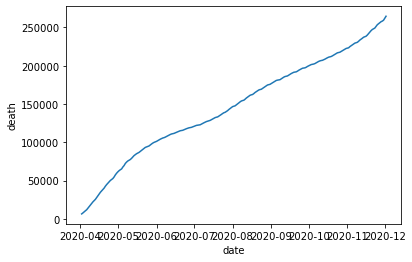

In [19]:
plt.ylabel('death')
plt.xlabel('date')
plt.plot(ts)

##### It is clearly evident that there is an overall increasing trend in the data 

## Check Stationarity Time Series Data

#### TS is said to be stationary if its statistical properties such as mean, variance remain constant over time
- constant mean
- constant variance
- an autocovariance that does not depend on time.

In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

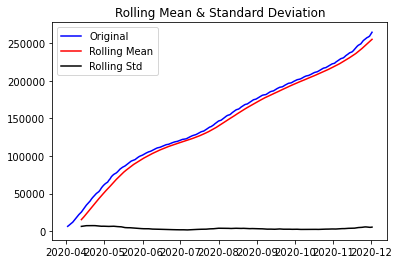

Results of Dickey-Fuller Test:
Test Statistic                   1.963591
p-value                          0.998624
#Lags Used                      16.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [22]:
test_stationarity(ts)

### The TS is stationary?

### This TS is not stationary:
- mean is increasing even though the std is small.
- Test stat is > critical value.

### How to make the Time Series Stationary
-The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

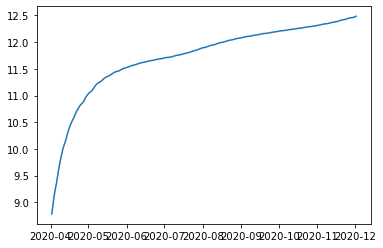

In [23]:
ts_log = np.log(ts)
plt.plot(ts_log)

## Moving Average

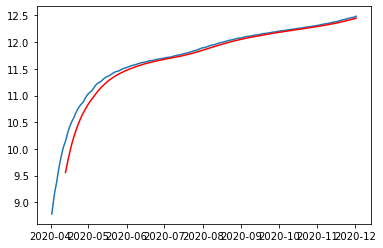

In [24]:
moving_avg = pd.Series.rolling(ts_log,12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [25]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

date
2020-04-02         NaN
2020-04-03         NaN
2020-04-04         NaN
2020-04-05         NaN
2020-04-06         NaN
2020-04-07         NaN
2020-04-08         NaN
2020-04-09         NaN
2020-04-10         NaN
2020-04-11         NaN
2020-04-12         NaN
2020-04-13    0.588359
Name: death, dtype: float64

#### The reason there are null values is because we take the average of first 12 so 11 values are null. We can also see that in the visual representation. Thus it is dropped for further analysis. Now let’s parse it to the function to check for stationarity.

In [26]:
ts_log_moving_avg_diff.dropna(inplace=True)

In [27]:
ts_log_moving_avg_diff.isnull().sum()

0

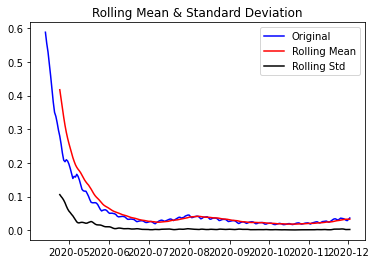

Results of Dickey-Fuller Test:
Test Statistic                -6.092385e+00
p-value                        1.029066e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64


In [28]:
test_stationarity(ts_log_moving_avg_diff)

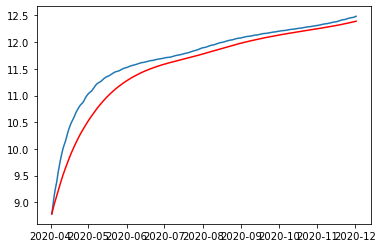

In [29]:
#the parameter ‘halflife’ is used to define the amount of exponential decay
#halflife? Is this the number of month/years data?
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

In [30]:
ts_log_ewma_diff = ts_log - expwighted_avg

In [31]:
ts_log_ewma_diff

date
2020-04-02    0.000000
2020-04-03    0.087422
2020-04-04    0.169115
2020-04-05    0.221220
2020-04-06    0.262218
                ...   
2020-11-28    0.087473
2020-11-29    0.085504
2020-11-30    0.084849
2020-12-01    0.089046
2020-12-02    0.093851
Name: death, Length: 245, dtype: float64

In [32]:
ts_log_ewma_diff.replace([np.inf, -np.inf], np.nan)

date
2020-04-02    0.000000
2020-04-03    0.087422
2020-04-04    0.169115
2020-04-05    0.221220
2020-04-06    0.262218
                ...   
2020-11-28    0.087473
2020-11-29    0.085504
2020-11-30    0.084849
2020-12-01    0.089046
2020-12-02    0.093851
Name: death, Length: 245, dtype: float64

In [33]:
ts_log_ewma_diff.fillna(0)

date
2020-04-02    0.000000
2020-04-03    0.087422
2020-04-04    0.169115
2020-04-05    0.221220
2020-04-06    0.262218
                ...   
2020-11-28    0.087473
2020-11-29    0.085504
2020-11-30    0.084849
2020-12-01    0.089046
2020-12-02    0.093851
Name: death, Length: 245, dtype: float64

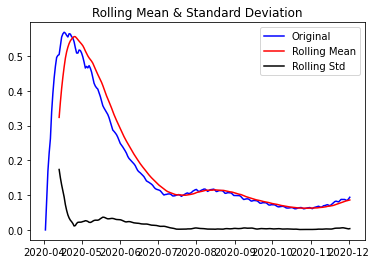

Results of Dickey-Fuller Test:
Test Statistic                  -3.256902
p-value                          0.016918
#Lags Used                      16.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [34]:
test_stationarity(ts_log_ewma_diff)

### Differencing
-One of the most common methods of dealing with both trend and seasonality is differencing

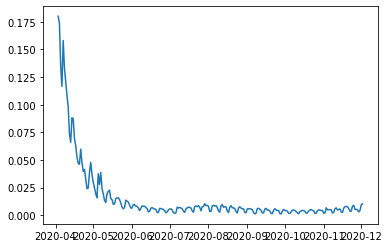

In [35]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

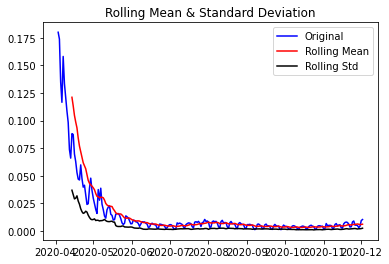

Results of Dickey-Fuller Test:
Test Statistic                  -3.699663
p-value                          0.004118
#Lags Used                      15.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [36]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

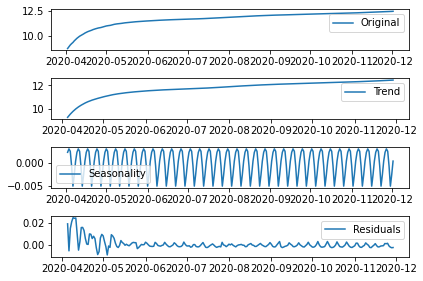

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Here we can see that the trend, seasonality are separated out from data and we can model the residuals.

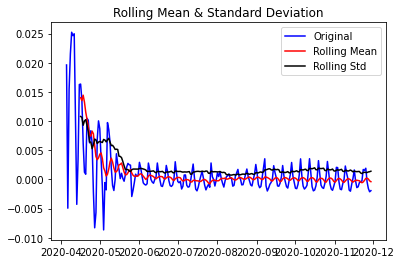

Results of Dickey-Fuller Test:
Test Statistic                  -5.332383
p-value                          0.000005
#Lags Used                      14.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


In [38]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

### Forecasting Time Series

In [39]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [40]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


Text(0.5, 1.0, 'Autocorrelation Function')

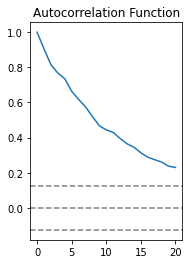

In [41]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

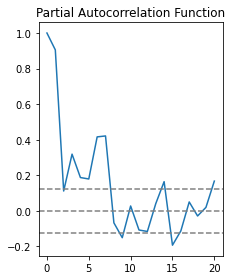

In [42]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [43]:
from statsmodels.tsa.arima_model import ARIMA

/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency infor

Text(0.5, 1.0, 'RSS: 0.0207')

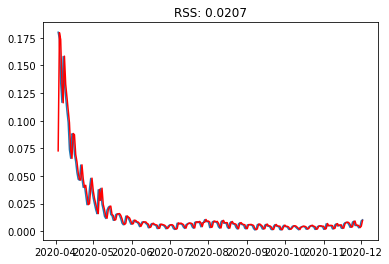

In [44]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

## MA Model

/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.0511')

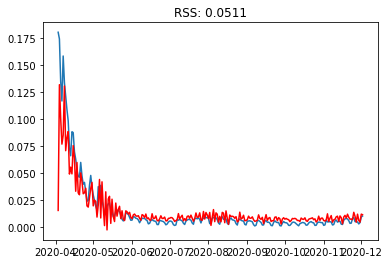

In [45]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

In [46]:
predictions_ARIMA_diff = pd.Series(results_MA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2020-04-03    0.015567
2020-04-04    0.131632
2020-04-05    0.100676
2020-04-06    0.076768
2020-04-07    0.084984
dtype: float64


In [47]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date
2020-04-03    0.015567
2020-04-04    0.147200
2020-04-05    0.247876
2020-04-06    0.324644
2020-04-07    0.409628
dtype: float64
